In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical

%matplotlib inline

DATA_DIR='/kaggle/input/8-facial-expressions-for-yolo/9 Facial Expressions you need'
train = os.listdir(os.path.join(DATA_DIR,'train'))
test = os.listdir(os.path.join(DATA_DIR,'test'))
val=os.listdir(os.path.join(DATA_DIR,'valid'))
print(f'Train - {train}')
print(f'Test - {test}')
print(f'Val - {val}')

IMG_SIZE = 48
EMOTIONS = ['Happy', 'Sad', 'Angry', 'Surprised', 'Neutral', 'Disgusted', 'Fear', 'Sleepy', 'Contempt']  # update based on your labels
emotion_to_idx = {e: i for i, e in enumerate(EMOTIONS)}
idx_to_emotion = {i: e for i, e in enumerate(EMOTIONS)} # Add mapping from index to emotion

def load_data(folder_path):
    image_dir = os.path.join(folder_path, 'images')
    label_dir = os.path.join(folder_path, 'labels')

    images = []
    labels = []

    # Get list of label files
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])

    for label_fname in label_files:
        image_fname = label_fname.replace('.txt', '.jpg')
        image_path = os.path.join(image_dir, image_fname)
        label_path = os.path.join(label_dir, label_fname)

        # Check if the corresponding image file exists
        if not os.path.exists(image_path):
            print(f"Warning: Image file not found for label file {label_path}. Skipping.")
            continue

        # Load image in grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Could not read image file {image_path}. Skipping.")
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 48×48
        images.append(img)

        # Load and parse label from YOLO format
        with open(label_path, 'r') as f:
            label_content = f.read().strip()
            # Assuming the first number in the line is the class ID
            try:
                class_id = int(label_content.split()[0])
                labels.append(class_id)
            except (ValueError, IndexError):
                print(f"Warning: Could not parse label from file {label_path}. Content: '{label_content}'. Skipping.")
                images.pop() # Remove the image if label parsing fails
                continue


    images = np.array(images)
    labels = np.array(labels)
    return images, labels
     

# Load full data from train folder
images, labels = load_data(os.path.join(DATA_DIR, 'test'))

# Normalize pixel values to be between 0 and 1
images = images / 255.0

# Reduce dataset size
n_train = 5000
n_test = 3000

train_images = images[:n_train]
train_labels = labels[:n_train]
test_images = images[-n_test:]
test_labels = labels[-n_test:]

# Add grayscale channel dimension: (N, 48, 48, 1)
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# One-hot encode the labels
train_labels_categorical = to_categorical(train_labels, num_classes=len(EMOTIONS))
test_labels_categorical = to_categorical(test_labels, num_classes=len(EMOTIONS))

# Final checks
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Train labels shape: {train_labels_categorical.shape}")
print(f"Test labels shape: {test_labels_categorical.shape}")

Train - ['labels', 'images']
Test - ['labels', 'images']
Val - ['labels', 'images']
Train images shape: (1700, 48, 48, 1)
Test images shape: (1700, 48, 48, 1)
Train labels shape: (1700, 9)
Test labels shape: (1700, 9)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers

# ----------------- Data Augmentation -----------------
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Fit the generator on training images
datagen.fit(train_images)

# ----------------- CNN Model -----------------
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # to prevent overfitting
    layers.Dense(len(EMOTIONS), activation='softmax')
])

# ----------------- Compile Model -----------------
model.compile(optimizer='adam',
              loss='categorical_crossentropy',   # since labels are one-hot encoded
              metrics=['accuracy'])

model.summary()

# ----------------- Training -----------------
batch_size = 32
epochs = 120

history = model.fit(
    datagen.flow(train_images, train_labels_categorical, batch_size=batch_size),
    validation_data=(test_images, test_labels_categorical),
    epochs=epochs
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1756208017.025762      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 485,513 (1.85 MB)

 Trainable params: 485,513 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1756208020.771313      94 service.cc:148] XLA service 0x7bd0b80023f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756208020.772282      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756208021.079897      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


14/54 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2128 - loss: 2.1170

I0000 00:00:1756208023.431908      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.2226 - loss: 2.0742 - val_accuracy: 0.2394 - val_loss: 1.9847
Epoch 2/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2213 - loss: 2.0151 - val_accuracy: 0.2394 - val_loss: 2.0118
Epoch 3/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2276 - loss: 2.0211 - val_accuracy: 0.2394 - val_loss: 1.9811
Epoch 4/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2361 - loss: 1.9859 - val_accuracy: 0.2394 - val_loss: 1.9990
Epoch 5/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2288 - loss: 1.9950 - val_accuracy: 0.2429 - val_loss: 1.9540
Epoch 6/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2232 - loss: 1.9885 - val_accuracy: 0.2400 - val_loss: 1.9442
Epoch 7/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2377 - loss: 1.9755 - val_accuracy: 0.2424 - val_loss: 1.9478
Epoch 8/120
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2329 - loss: 1.9656 - val_accuracy: 0.2724 - val_l

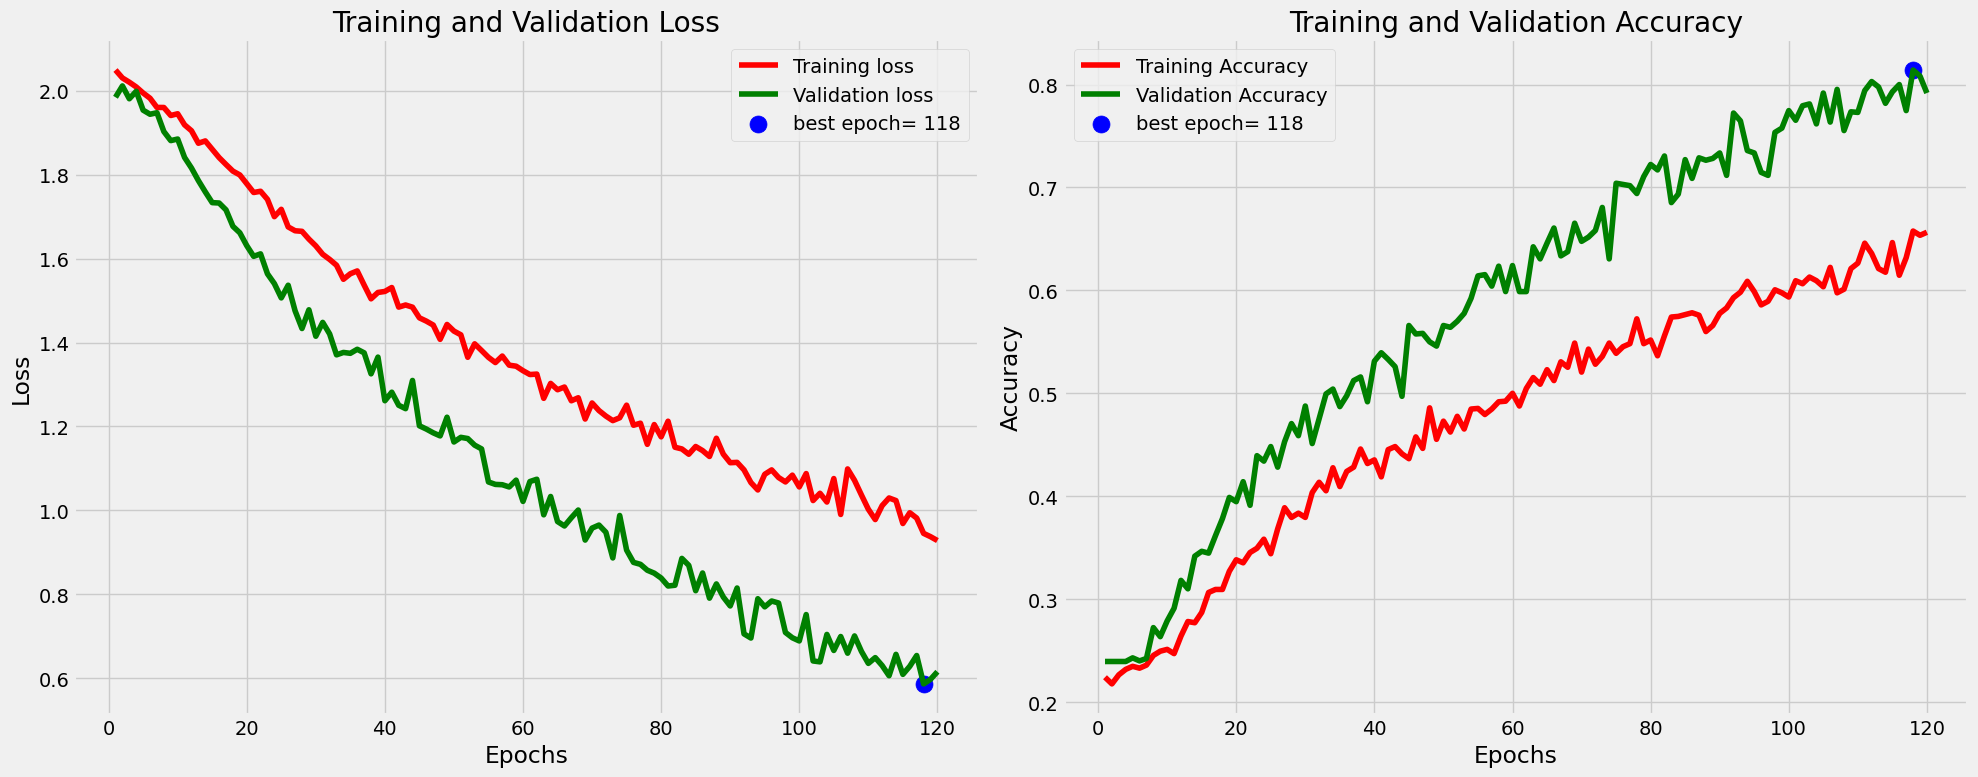

54/54 - 0s - 3ms/step - accuracy: 0.7918 - loss: 0.6153
Test Loss: 0.6153
Test Accuracy: 0.7918
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

       Happy       0.77      0.72      0.75       297
         Sad       0.85      0.49      0.62        68
       Angry       0.73      0.68      0.71        98
   Surprised       0.77      0.79      0.78       144
     Neutral       0.83      0.95      0.89       407
   Disgusted       0.74      0.58      0.65       136
        Fear       0.79      0.78      0.78       298
      Sleepy       0.96      0.73      0.83        33
    Contempt       0.79      0.89      0.83       219

    accuracy                           0.79      1700
   macro avg       0.80      0.73      0.76      1700
weighted avg       0.79      0.79      0.79      1700



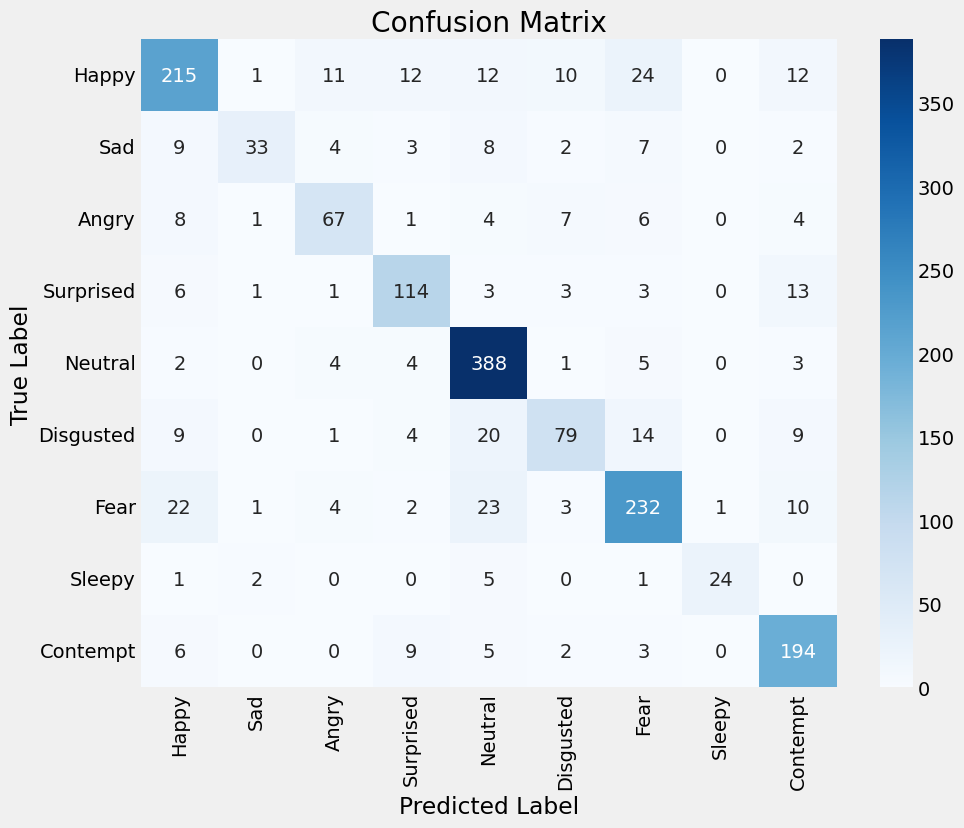

In [5]:
import seaborn as sns
# =============================
# Training History Visualization
# =============================

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# =============================
# Evaluate the model on the test set
# =============================
test_loss, test_accuracy = model.evaluate(test_images, test_labels_categorical, verbose=2)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# =============================
# Predictions and Classification Report
# =============================
from sklearn.metrics import classification_report, confusion_matrix

# Convert one-hot back to integer labels for ground truth
true_labels = np.argmax(test_labels_categorical, axis=1)

# Predictions
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=EMOTIONS))

# =============================
# Confusion Matrix
# =============================
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=EMOTIONS,
            yticklabels=EMOTIONS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
